In [1]:
import numpy as np
import pandas as pd
import scipy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scipy.stats import beta

# Step 1: Load in the data and fit the EB prior

In [2]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [3]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 0.4
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [4]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [5]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4, random_state=1729)

In [6]:
def transform_values(i,n,prior=1/2):
    return (i*(n-1)+prior)/n

In [7]:
prior_a, prior_b, loc, scale = beta.fit([transform_values(i, len(train_videos.values),1/2)
                                          for i in train_videos.values], floc=0, fscale=1)

In [8]:
# prior_a *= 10
# prior_b *= 10
# print(prior_a, prior_b)

# Step 2: Over-time analysis

In [9]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.sort_values(['video_id', 'timestamp'])
kuairec_test = kuairec_test[~kuairec_test['timestamp'].isnull()]
kuairec_test['recentness'] = kuairec_test.groupby(['video_id']).cumcount()+1
# kuairec_test = kuairec_test[kuairec_test['recentness'] <= 100]
kuairec_test = kuairec_test.rename(columns={'liked_x': "liked"})
kuairec_test.shape

(1801572, 11)

In [10]:
kuairec_calibrate = kuairec_test[kuairec_test['recentness'] <= 50]
kuairec_eval = kuairec_test[kuairec_test['recentness'] > 50]

In [11]:
test_df_videos = set(kuairec_test['video_id'])

In [12]:
etas = np.linspace(0,1,11)
prior_set = np.vstack([prior_a*etas + (1 - etas), prior_b*etas + (1-etas)]).T
prior_set

array([[1.        , 1.        ],
       [1.04270966, 0.95916156],
       [1.08541932, 0.91832313],
       [1.12812898, 0.87748469],
       [1.17083864, 0.83664626],
       [1.21354829, 0.79580782],
       [1.25625795, 0.75496939],
       [1.29896761, 0.71413095],
       [1.34167727, 0.67329252],
       [1.38438693, 0.63245408],
       [1.42709659, 0.59161565]])

In [13]:
calibration_df = {'alpha': [], 'beta': [], 'eta': [], 'num_samples': [], 'video_id': []}
max_calibration_samples = 50

In [14]:
for i in range(len(etas)):
    print(f'eta value {i+1}/11')
    for vid_id in set(kuairec_test['video_id']):
        for j in range(1,max_calibration_samples+1):
            used_results = kuairec_calibrate[(kuairec_calibrate['video_id']==vid_id) 
                                             & (kuairec_calibrate['recentness'] <= j)]
            a = used_results.sum()['liked'] + prior_set[i,0]
            b = j - a + prior_set[i,0] + prior_set[i,1]
            calibration_df['alpha'].append(a)
            calibration_df['beta'].append(b)
            calibration_df['eta'].append(etas[i])
            calibration_df['num_samples'].append(j)
            calibration_df['video_id'].append(vid_id)
            
            
            

eta value 1/11
eta value 2/11
eta value 3/11
eta value 4/11
eta value 5/11
eta value 6/11
eta value 7/11
eta value 8/11
eta value 9/11
eta value 10/11
eta value 11/11


In [15]:
calibration_df = pd.DataFrame(calibration_df)
calibration_df['est_quality'] = calibration_df['alpha']/(calibration_df['alpha']+calibration_df['beta'])

In [16]:
calibration_df.head()

,alpha,beta,eta,num_samples,video_id,est_quality
0,2.0,1.0,0.0,1,8195,0.666667
1,3.0,1.0,0.0,2,8195,0.750000
2,4.0,1.0,0.0,3,8195,0.800000
3,4.0,2.0,0.0,4,8195,0.666667
4,5.0,2.0,0.0,5,8195,0.714286


In [17]:
evaluation_df = kuairec_eval.groupby('video_id')['liked'].sum().reset_index()
evaluation_df = evaluation_df.rename(columns={'liked': 'alpha_true'})
evaluation_df = pd.merge(evaluation_df, kuairec_eval.groupby('video_id')['liked'].count().reset_index(), on='video_id')
evaluation_df['liked'] = evaluation_df['liked'] - evaluation_df['alpha_true']
evaluation_df = evaluation_df.rename(columns={'liked': 'beta_true'})
evaluation_df['true_quality'] = evaluation_df['alpha_true']/(evaluation_df['alpha_true'] + evaluation_df['beta_true'])
evaluation_df.head()

,video_id,alpha_true,beta_true,true_quality
0,120,1210,98,0.925076
1,130,1082,156,0.873990
2,137,1071,210,0.836066
3,142,1107,137,0.889871
4,147,943,304,0.756215


In [60]:
results_df = pd.merge(calibration_df, evaluation_df, on='video_id')
results_df['eta'] = np.round(results_df['eta'],1)
results_df.head()

,alpha,beta,eta,num_samples,video_id,est_quality,alpha_true,beta_true,true_quality
0,2.0,1.0,0.0,1,8195,0.666667,1232,79,0.939741
1,3.0,1.0,0.0,2,8195,0.750000,1232,79,0.939741
2,4.0,1.0,0.0,3,8195,0.800000,1232,79,0.939741
3,4.0,2.0,0.0,4,8195,0.666667,1232,79,0.939741
4,5.0,2.0,0.0,5,8195,0.714286,1232,79,0.939741


In [61]:
results_df['mse'] = np.square(results_df['true_quality'] - results_df['est_quality'])

In [62]:
results_df.head()

,alpha,beta,eta,num_samples,video_id,est_quality,alpha_true,beta_true,true_quality,mse
0,2.0,1.0,0.0,1,8195,0.666667,1232,79,0.939741,0.074569
1,3.0,1.0,0.0,2,8195,0.750000,1232,79,0.939741,0.036002
2,4.0,1.0,0.0,3,8195,0.800000,1232,79,0.939741,0.019527
3,4.0,2.0,0.0,4,8195,0.666667,1232,79,0.939741,0.074569
4,5.0,2.0,0.0,5,8195,0.714286,1232,79,0.939741,0.050830


In [63]:
to_graph = results_df.groupby(['num_samples', 'eta'])['mse'].mean().reset_index()

<AxesSubplot:xlabel='num_samples', ylabel='mse'>

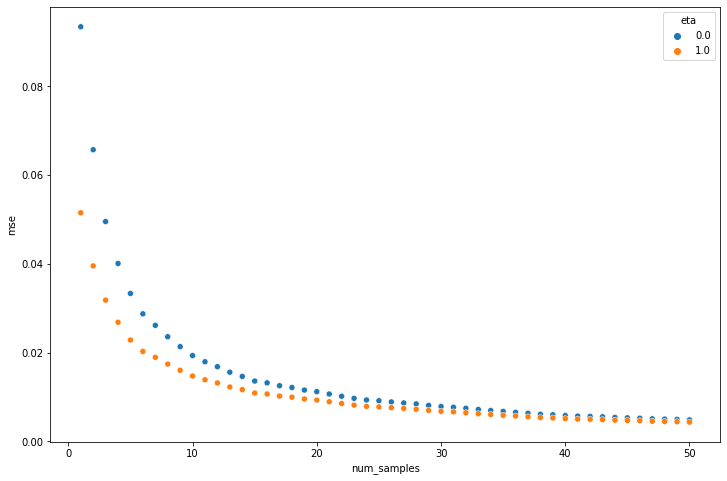

In [64]:
plt.gcf().set_size_inches(12,8)
sns.scatterplot(data=to_graph[to_graph['eta'].isin([0.0, 1.0])], x='num_samples', y='mse', hue='eta')

In [65]:
results_df['rounded_true_qual'] = np.round(results_df['true_quality'],1)
results_df.head()

,alpha,beta,eta,num_samples,video_id,est_quality,alpha_true,beta_true,true_quality,mse,rounded_true_qual
0,2.0,1.0,0.0,1,8195,0.666667,1232,79,0.939741,0.074569,0.9
1,3.0,1.0,0.0,2,8195,0.750000,1232,79,0.939741,0.036002,0.9
2,4.0,1.0,0.0,3,8195,0.800000,1232,79,0.939741,0.019527,0.9
3,4.0,2.0,0.0,4,8195,0.666667,1232,79,0.939741,0.074569,0.9
4,5.0,2.0,0.0,5,8195,0.714286,1232,79,0.939741,0.050830,0.9


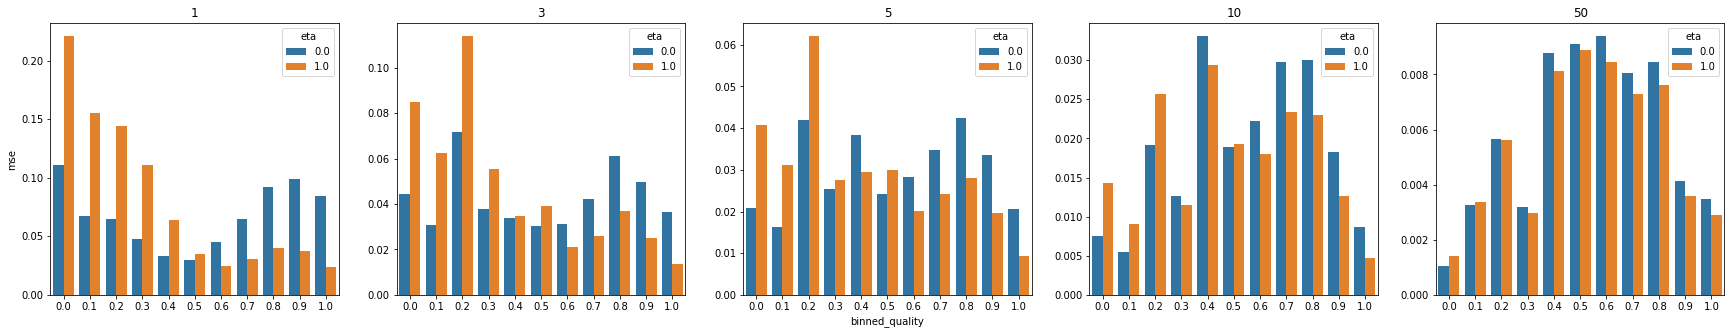

In [66]:
training_examples = [1,3,5,10,50]
f, axes = plt.subplots(1,5)
f.set_size_inches(30,5)
for i in range(len(training_examples)):
    x_label = 'binned_quality' if i==2 else None
    y_label = 'mse' if i==0 else None
    f.sca(axes[i])
    to_graph = results_df.groupby(['rounded_true_qual','num_samples','eta'])['mse'].mean().reset_index()
    to_graph = to_graph[(to_graph['eta'].isin([0.0,1.0])) & (to_graph['num_samples']==training_examples[i])]
    plt.title(training_examples[i])
    sns.barplot(data=to_graph, x='rounded_true_qual', y='mse', hue='eta').set(ylabel=y_label, xlabel=x_label)

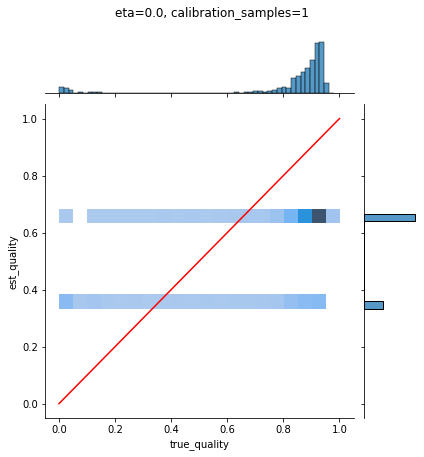

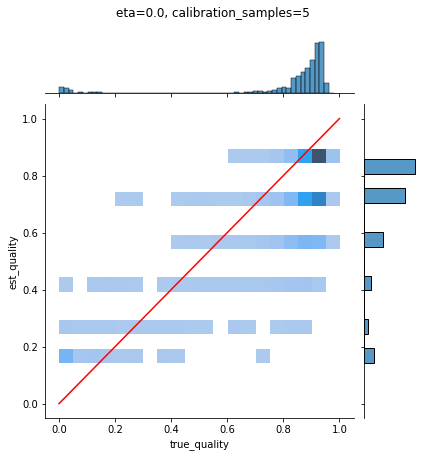

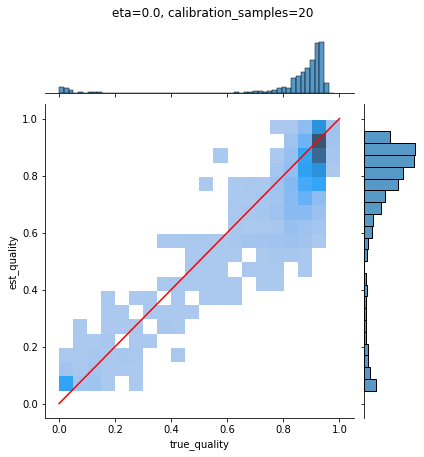

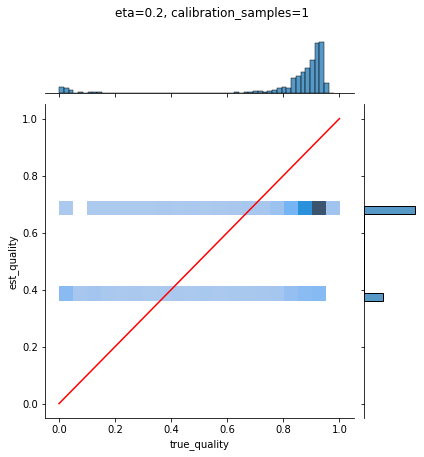

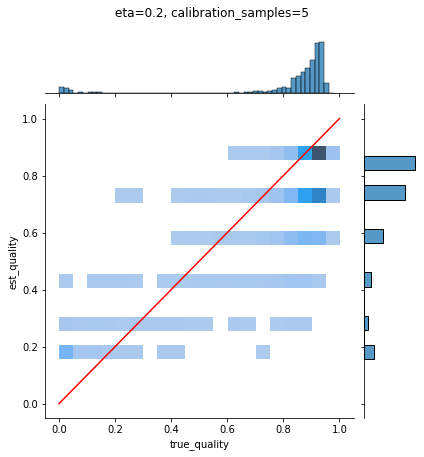

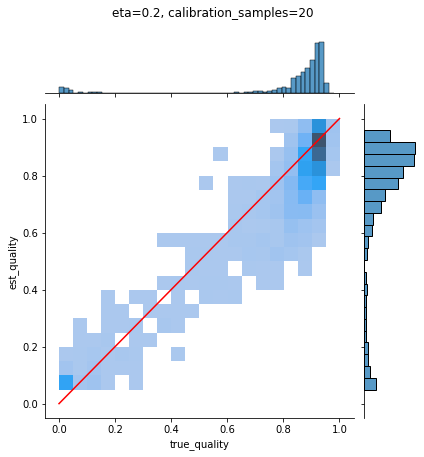

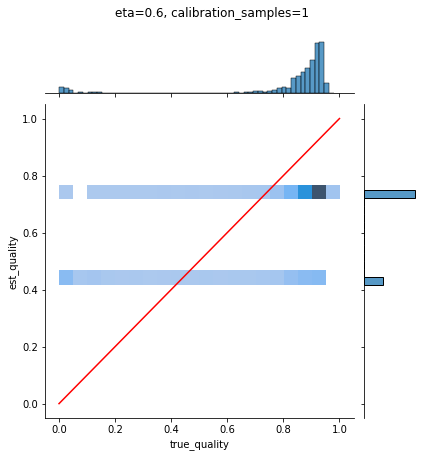

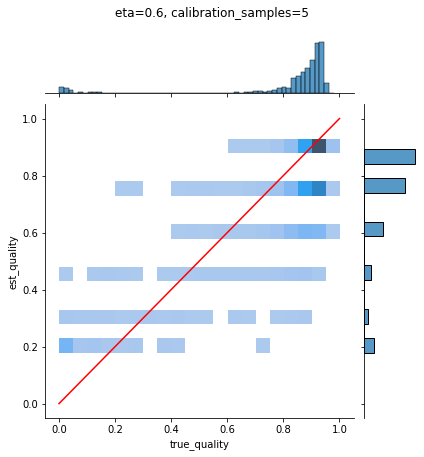

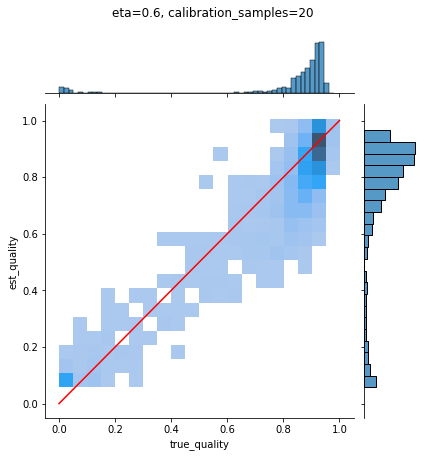

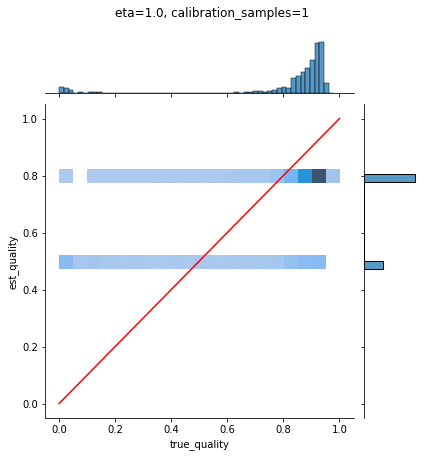

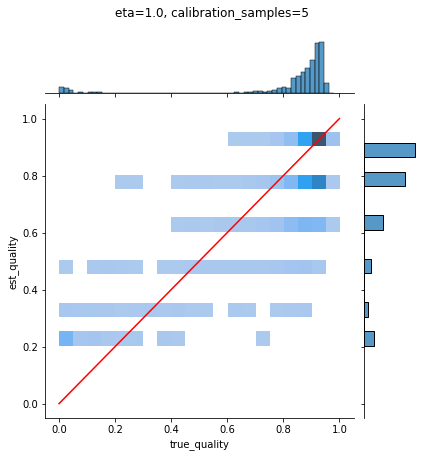

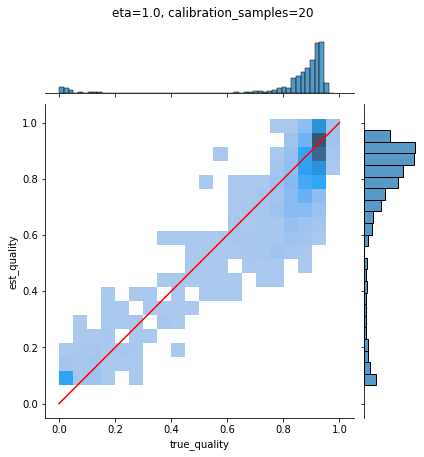

In [84]:
etas = [0.0,0.2,0.6,1.0]
num_samples = [1,5,20]
for i in range(len(etas)):
    for j in range(len(num_samples)):
        to_graph = results_df[(results_df['eta']==etas[i]) & (results_df['num_samples']==num_samples[j])]
        p = sns.jointplot(data=to_graph, x='true_quality',y='est_quality',kind='hist',binwidth=0.05)
        p.fig.suptitle(f'eta={etas[i]}, calibration_samples={num_samples[j]}',y=1.05)
        plt.plot([0,1],[0,1], color='red')